Optimal TF-IDF threshold: 0.0002, Optimal dropout (d): 0.7
Optimal clustering threshold: 0.6
Optimal TF-IDF threshold: 0.0002, Optimal dropout (d): 0.7
Optimal clustering threshold: 0.6
Optimal TF-IDF threshold: 0.0002, Optimal dropout (d): 0.4
Optimal clustering threshold: 0.7999999999999999
Optimal TF-IDF threshold: 0.0002, Optimal dropout (d): 0.4
Optimal clustering threshold: 0.7999999999999999
Optimal TF-IDF threshold: 0.0004000000000000001, Optimal dropout (d): 0.5
Optimal clustering threshold: 0.7
Optimal TF-IDF threshold: 0.0004000000000000001, Optimal dropout (d): 0.5
Optimal clustering threshold: 0.4


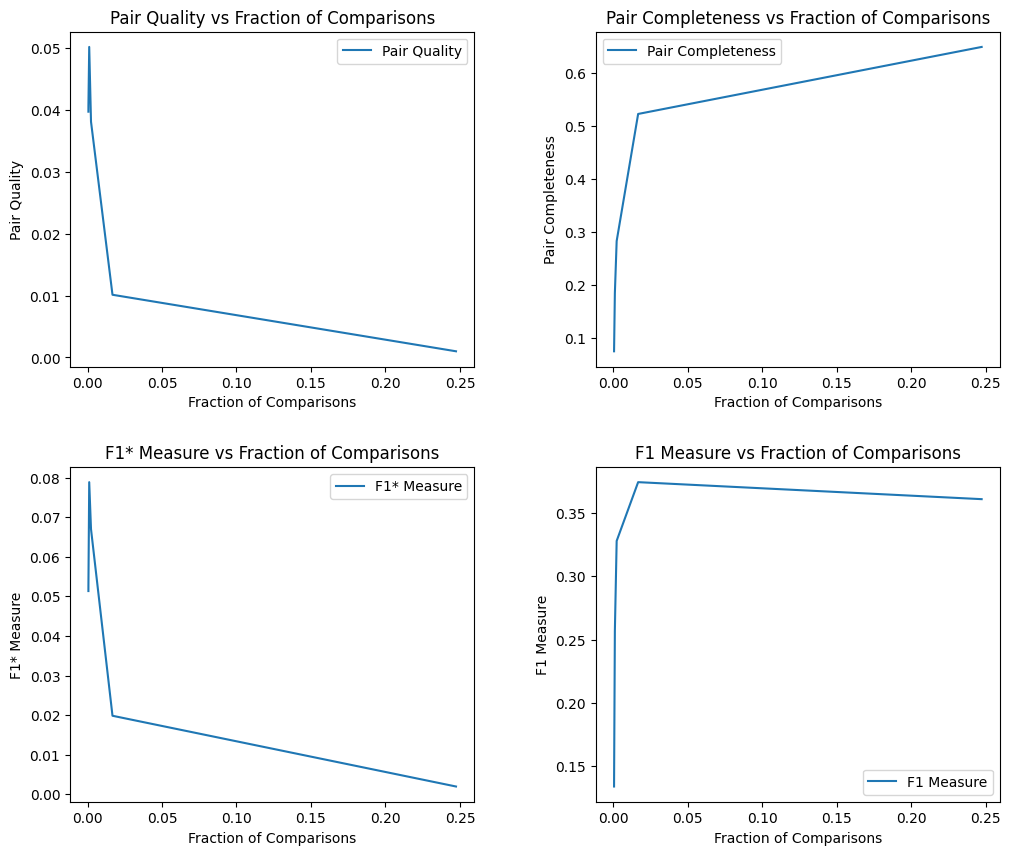

   Pair Quality  Pair Completeness       F1*        F1  Fraction Comparisons  \
0      0.000993           0.648845  0.001982  0.360759              0.247341   
1      0.010125           0.522497  0.019844  0.374172              0.016772   
2      0.038084           0.282861  0.066960  0.327795              0.002355   
3      0.050164           0.184698  0.078826  0.256721              0.001148   
4      0.040712           0.078548  0.052971  0.139296              0.000623   
5      0.039704           0.075040  0.051331  0.134010              0.000607   

    r   b  
0   2  40  
1   4  20  
2   8  10  
3  10   8  
4  20   4  
5  40   2  


In [4]:
import pandas as pd
import numpy as np
import random
import re
from collections import defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

# === Data Preparation ===
# Load dataset
df = pd.read_excel('tv_data.xlsx')
if 'url' in df.columns:
    df = df.drop(columns=['url'])

def clean_text_advanced(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\b(newegg\.com|thenerds\.net|best buy)\b', ' ', text)
    text = re.sub(r'(\d+)"', r'\1inch', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\b(inches|\"|-inch| inch)\b', 'inch', text)
    text = re.sub(r'\b(hertz|hz|hz|-hz)\b', 'hz', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# List of known TV brands
tv_brands = [
    "toshiba", "sony", "samsung", "sharp", "lg", "vizio", "panasonic", "jvc",
    "philips", "haier", "insignia", "nec", "hisense", "sanyo", "seiki", "dynex",
    "sansui", "optoma", "tcl", "viewsonic", "westinghouse", "coby", "pyle",
    "proscan", "affinity", "elite", "craig", "naxa", "curtisyoung", "hiteker",
    "sunbritetv", "azend", "magnavox", "supersonic", "epson", "hello kitty",
    "rca", "venturer", "sceptre", "open box", "compaq", "hannspree", "upstar",
    "sigmac", "avue", "elo", "contex", "gpx", "venturer"
]

def extract_strict_model_words(text):
    pattern = r'[a-zA-Z]*[0-9]+[a-zA-Z]+|[a-zA-Z]+[0-9]+[a-zA-Z]*'
    matches = re.findall(pattern, text)
    return ' '.join(matches)

def prepare_strict_model_words(df):
    df_titles = df[['title']].copy()
    df_only_strict_model_words = pd.DataFrame()
    df_only_strict_model_words['strict_model_words'] = df_titles['title'].apply(extract_strict_model_words)
    df_only_strict_model_words['product_id'] = df_titles.index
    df_only_strict_model_words.set_index('product_id', inplace=True)
    df_only_strict_model_words['strict_model_words_combined'] = df_only_strict_model_words['strict_model_words'].apply(lambda x: ' '.join(x.split()))
    return df_only_strict_model_words[df_only_strict_model_words['strict_model_words_combined'].str.strip() != ""]

def filter_important_model_words(model_words, important_words_set):
    product_words = model_words.split()
    return ' '.join([word for word in product_words if word in important_words_set])

# === Generate TF-IDF and Binary Vectors ===
def generate_binary_vectors(df_only_strict_model_words, tfidf_threshold):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df_only_strict_model_words['strict_model_words_combined'])
    terms = vectorizer.get_feature_names_out()
    tfidf_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
    tfidf_scores['product_id'] = df_only_strict_model_words.index
    tfidf_scores.set_index('product_id', inplace=True)

    # Filter important words
    average_tfidf_scores = tfidf_scores.mean(axis=0).reset_index()
    average_tfidf_scores.columns = ['model_word', 'average_tfidf_score']
    average_tfidf_scores = average_tfidf_scores.sort_values(by='average_tfidf_score', ascending=False)
    average_tfidf_scores.set_index('model_word', inplace=True)
    important_words = average_tfidf_scores[average_tfidf_scores['average_tfidf_score'] > tfidf_threshold].index.tolist()
    important_words_set = set(important_words) 
    df_only_strict_model_words['filtered_model_words'] = df_only_strict_model_words['strict_model_words'].apply(
        lambda x: filter_important_model_words(x, important_words_set))

    # Create binary vectors
    binary_vectors = pd.DataFrame(0, index=df_only_strict_model_words.index, columns=important_words)
    for product_id, row in df_only_strict_model_words.iterrows():
        product_words = set(row['filtered_model_words'].split())
        for word in product_words:
            if word in binary_vectors.columns:
                binary_vectors.at[product_id, word] = 1
    return binary_vectors

# === Generate Signature Matrix ===
def generate_signature_matrix(binary_vectors, n_permutations):
    n_products, n_features = binary_vectors.shape
    signature_matrix = np.full((n_permutations, n_products), np.inf)
    for perm_idx in range(n_permutations):
        permuted_indices = np.random.permutation(n_features)
        for prod_idx in range(n_products):
            product_vector = binary_vectors.iloc[prod_idx].values
            for idx in permuted_indices:
                if product_vector[idx] == 1:
                    signature_matrix[perm_idx, prod_idx] = idx
                    break
            if signature_matrix[perm_idx, prod_idx] == np.inf:
                signature_matrix[perm_idx, prod_idx] = n_features + perm_idx
    return signature_matrix


# === Apply LSH and Generate Candidate Pairs ===
def apply_lsh(signature_matrix, b, r, d):
    def custom_hash(band_signature, a, c, p):
        value = 0
        for i, x in enumerate(band_signature):
            try:
                value += int(x) * (10 ** i)  
            except (ValueError, OverflowError):
                value += (10 ** i)  
        return (a * value + c) % p

    num_products = signature_matrix.shape[1]
    buckets = [defaultdict(list) for _ in range(b)]  

    # Parameters for the custom hash function
    a, c, p = random.randint(1, 1000), random.randint(1, 1000), 104729  

    # Apply dropout
    selected_bands = random.sample(range(b), int(b * (1 - d)))  # Select (1-d) * b bands

    for band_idx in selected_bands:  # Only process the selected bands
        start_row = band_idx * r
        end_row = start_row + r
        band = signature_matrix[start_row:end_row, :] 

        for col_idx in range(num_products):
            # Convert band into a tuple (mini-signature)
            band_signature = tuple(band[:, col_idx])
            # Apply custom hash function to the band signature
            hash_value = custom_hash(band_signature, a, c, p)
            buckets[band_idx][hash_value].append(col_idx)

    return buckets

def generate_candidate_pairs(buckets):
    candidate_pairs = set()
    for band in buckets:
        for bucket_key, indices in band.items():
            if len(indices) > 1:
                candidate_pairs.update(combinations(indices, 2))
    return candidate_pairs

# === Calculate Dissimilarity Matrix ===
def calculate_dissimilarity_matrix(binary_vectors, candidate_pairs, df, tv_brands):
    n_products = binary_vectors.shape[0]
    dissimilarity_matrix = np.full((n_products, n_products), np.inf)

    for pair in candidate_pairs:
        i, j = pair
        if i not in df.index or j not in df.index:
            continue

        brand_i = next((brand for brand in tv_brands if brand in df.loc[i, 'title']), None)
        brand_j = next((brand for brand in tv_brands if brand in df.loc[j, 'title']), None)
        if brand_i != brand_j:
            continue

        shop_i = df.loc[i, 'shop']
        shop_j = df.loc[j, 'shop']
        if shop_i == shop_j:
            continue

        vec_i = binary_vectors.iloc[i].values
        vec_j = binary_vectors.iloc[j].values
        intersection = np.sum(np.logical_and(vec_i, vec_j))
        union = np.sum(np.logical_or(vec_i, vec_j))
        dissimilarity_matrix[i, j] = 1 - (intersection / union) if union != 0 else 1
        dissimilarity_matrix[j, i] = dissimilarity_matrix[i, j]

    return dissimilarity_matrix

# === Perform Clustering ===
def perform_clustering(dissimilarity_matrix, threshold):
    np.fill_diagonal(dissimilarity_matrix, 0)
    dissimilarity_matrix[np.isinf(dissimilarity_matrix)] = 1.0
    clustering = AgglomerativeClustering(
        metric='precomputed', linkage='complete', distance_threshold=threshold, n_clusters=None
    )
    clustering.fit(dissimilarity_matrix)
    return clustering.labels_

def generate_predicted_duplicates(cluster_labels):
    predicted_duplicates = []
    for cluster_id in np.unique(cluster_labels):
        members = np.where(cluster_labels == cluster_id)[0]
        if len(members) > 1:
            predicted_duplicates.extend(list(combinations(members, 2)))
    return predicted_duplicates

def find_real_duplicates(df):
    real_duplicates = []
    for model_id, group in df.groupby('modelID'):
        if len(group) > 1:
            indices = group.index.tolist()
            real_duplicates.extend(list(combinations(indices, 2)))
    return real_duplicates

# === Evaluate Performance ===
def evaluate_performance(predicted_duplicates, real_duplicates, candidate_pairs, total_products):
    predicted_set = set(predicted_duplicates)
    real_set = set(real_duplicates)

    TP = len(predicted_set & real_set)
    FP = len(predicted_set - real_set)
    FN = len(real_set - predicted_set)

    total_comparisons = total_products * (total_products - 1) / 2
    fraction_comparisons = len(candidate_pairs) / total_comparisons

    pair_quality = TP / len(candidate_pairs) if len(candidate_pairs) > 0 else 0
    pair_completeness = TP / len(real_duplicates) if len(real_duplicates) > 0 else 0

    F1_star = 2 * (pair_quality * pair_completeness) / (pair_quality + pair_completeness) if (pair_quality + pair_completeness) > 0 else 0

    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    return {
        'Pair Quality': pair_quality,
        'Pair Completeness': pair_completeness,
        'F1*': F1_star,
        'F1': F1,
        'Fraction Comparisons': fraction_comparisons
    }

def performance(data, r, b, threshold, tfidf_threshold, d):
    if 'url' in data.columns:
        data = data.drop(columns=['url'])
    data['title'] = data['title'].apply(clean_text_advanced)

    df_only_strict_model_words = prepare_strict_model_words(data)

    binary_vectors = generate_binary_vectors(df_only_strict_model_words, tfidf_threshold)

    n_permutations = r * b
    signature_matrix = generate_signature_matrix(binary_vectors, n_permutations)

    buckets = apply_lsh(signature_matrix, b, r, d)
    candidate_pairs = generate_candidate_pairs(buckets)

    dissimilarity_matrix = calculate_dissimilarity_matrix(binary_vectors, candidate_pairs, data, tv_brands)

    cluster_labels = perform_clustering(dissimilarity_matrix, threshold)

    predicted_duplicates = generate_predicted_duplicates(cluster_labels)
    real_duplicates = find_real_duplicates(data)

    total_products = len(data)
    return evaluate_performance(predicted_duplicates, real_duplicates, candidate_pairs, total_products)

# === Bootstrap Function ===
def create_bootstrap_samples(data, n_bootstraps=5):
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        train_data = resample(data, replace=True, n_samples=len(data), random_state=random.randint(0, 10000))
        test_data = data.loc[~data.index.isin(train_data.index)]
        
        if train_data.empty or test_data.empty:
            continue

        train_data = train_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)
        bootstrap_samples.append((train_data, test_data))
    return bootstrap_samples

# === Optimization and Evaluation Functions ===
def optimize_tfidf_d(data, bootstrap_samples, r, b, thresholds_tfidf, dropout_values):
    """Optimize TF-IDF and dropout (d) for F1*."""
    best_tfidf, best_dropout, best_f1_star = None, None, -1

    for tfidf_threshold in thresholds_tfidf:
        for d in dropout_values:
            avg_f1_star = 0
            for train, _ in bootstrap_samples:
                result = performance(train, r, b, threshold=0.5, tfidf_threshold=tfidf_threshold, d=d)
                avg_f1_star += result['F1*']
            avg_f1_star /= len(bootstrap_samples)

            if avg_f1_star > best_f1_star:
                best_f1_star, best_tfidf, best_dropout = avg_f1_star, tfidf_threshold, d

    print(f"Optimal TF-IDF threshold: {best_tfidf}, Optimal dropout (d): {best_dropout}")
    return best_tfidf, best_dropout

def optimize_clustering_threshold(data, bootstrap_samples, r, b, tfidf_threshold, d, thresholds_clustering):
    """Optimize clustering threshold for F1."""
    best_threshold, best_f1 = None, -1

    for threshold in thresholds_clustering:
        avg_f1 = 0
        for train, _ in bootstrap_samples:
            result = performance(train, r, b, threshold, tfidf_threshold, d)
            avg_f1 += result['F1']
        avg_f1 /= len(bootstrap_samples)

        if avg_f1 > best_f1:
            best_f1, best_threshold = avg_f1, threshold

    print(f"Optimal clustering threshold: {best_threshold}")
    return best_threshold

def evaluate_r_b_combinations(data, bootstrap_samples, r_b_pairs, thresholds_tfidf, dropout_values, thresholds_clustering):
    """Evaluate all r-b combinations with optimized parameters."""
    scores = []
    for r, b in r_b_pairs:
        # Step 1: Optimize TF-IDF and d for F1*
        best_tfidf, best_dropout = optimize_tfidf_d(data, bootstrap_samples, r, b, thresholds_tfidf, dropout_values)
        
        # Step 2: Optimize clustering threshold for F1
        best_threshold = optimize_clustering_threshold(data, bootstrap_samples, r, b, best_tfidf, best_dropout, thresholds_clustering)

        # Step 3: Evaluate performance using the optimized parameters
        avg_results = {
            'Pair Quality': 0,
            'Pair Completeness': 0,
            'F1*': 0,
            'F1': 0,
            'Fraction Comparisons': 0
        }
        for _, test in bootstrap_samples:
            result = performance(test, r, b, best_threshold, best_tfidf, best_dropout)
            for metric in avg_results.keys():
                avg_results[metric] += result[metric]
        for metric in avg_results.keys():
            avg_results[metric] /= len(bootstrap_samples)
        avg_results['r'] = r
        avg_results['b'] = b
        scores.append(avg_results)
    return pd.DataFrame(scores)

# === Visualization ===
def plot_graphs(results):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    axs[0, 0].plot(results['Fraction Comparisons'], results['Pair Quality'], linestyle='-', linewidth=1.5, label='Pair Quality')
    axs[0, 0].set_xlabel('Fraction of Comparisons')
    axs[0, 0].set_ylabel('Pair Quality')
    axs[0, 0].set_title('Pair Quality vs Fraction of Comparisons')
    axs[0, 0].legend()

    axs[0, 1].plot(results['Fraction Comparisons'], results['Pair Completeness'], linestyle='-', linewidth=1.5, label='Pair Completeness')
    axs[0, 1].set_xlabel('Fraction of Comparisons')
    axs[0, 1].set_ylabel('Pair Completeness')
    axs[0, 1].set_title('Pair Completeness vs Fraction of Comparisons')
    axs[0, 1].legend()

    axs[1, 0].plot(results['Fraction Comparisons'], results['F1*'], linestyle='-', linewidth=1.5, label='F1* Measure')
    axs[1, 0].set_xlabel('Fraction of Comparisons')
    axs[1, 0].set_ylabel('F1* Measure')
    axs[1, 0].set_title('F1* Measure vs Fraction of Comparisons')
    axs[1, 0].legend()

    axs[1, 1].plot(results['Fraction Comparisons'], results['F1'], linestyle='-', linewidth=1.5, label='F1 Measure')
    axs[1, 1].set_xlabel('Fraction of Comparisons')
    axs[1, 1].set_ylabel('F1 Measure')
    axs[1, 1].set_title('F1 Measure vs Fraction of Comparisons')
    axs[1, 1].legend()

    plt.savefig("grafieken_paper.pdf", format="pdf", bbox_inches="tight")

    plt.show()

# === Main Function ===
def main(data):
    bootstrap_samples = create_bootstrap_samples(data, n_bootstraps=5)

    thresholds_tfidf = np.arange(0.0002, 0.0005, 0.0001)
    dropout_values = np.arange(0.4, 0.8, 0.1)
    thresholds_clustering = np.arange(0.4, 0.9, 0.1)
    r_b_pairs = [(2, 40), (4, 20), (8, 10), (10, 8), (20, 4), (40, 2)]

    results = evaluate_r_b_combinations(data, bootstrap_samples, r_b_pairs, thresholds_tfidf, dropout_values, thresholds_clustering)

    plot_graphs(results)
    return results

# Run the program
results_df = main(df)
print(results_df)